In [1]:
import graphlab
from __future__ import division
import numpy as np
graphlab.canvas.set_target('ipynb')

A newer version of GraphLab Create (v1.8.5) is available! Your current version is v1.8.3.

You can use pip to upgrade the graphlab-create package. For more information see https://dato.com/products/create/upgrade.


In [2]:
products = graphlab.SFrame('amazon_baby.gl/')

[INFO] GraphLab Create v1.8.3 started. Logging: C:\Users\ritraina\AppData\Local\Temp\graphlab_server_1460950156.log.0


In [3]:
def remove_punctuation(text):
    import string
    return text.translate(None, string.punctuation) 

# Remove punctuation.
review_clean = products['review'].apply(remove_punctuation)

# Count words
products['word_count'] = graphlab.text_analytics.count_words(review_clean)

# Drop neutral sentiment reviews.
products = products[products['rating'] != 3]

# Positive sentiment to +1 and negative sentiment to -1
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)

In [4]:
products

name,review,rating,word_count,sentiment
Planetwise Wipe Pouch,it came early and was notdisappointed. i love ...,5.0,"{'and': 3L, 'love': 1L,'it': 3L, 'highly': 1L, ...",1
Annas Dream Full Quiltwith 2 Shams ...,Very soft and comfortableand warmer than it ...,5.0,"{'and': 2L, 'quilt': 1L,'it': 1L, 'comfortable': ...",1
Stop Pacifier Suckingwithout tears with ...,This is a product wellworth the purchase. I ...,5.0,"{'and': 3L, 'ingenious':1L, 'love': 2L, 'is': ...",1
Stop Pacifier Suckingwithout tears with ...,All of my kids have criednon-stop when I tried to ...,5.0,"{'and': 2L, 'all': 2L,'help': 1L, 'cried': 1L, ...",1
Stop Pacifier Suckingwithout tears with ...,"When the Binky Fairy cameto our house, we didn't ...",5.0,"{'and': 2L, 'cute': 1L,'help': 2L, 'habit': 1L, ...",1
A Tale of Baby's Dayswith Peter Rabbit ...,"Lovely book, it's boundtightly so you may no ...",4.0,"{'shop': 1L, 'be': 1L,'is': 1L, 'bound': 1L, ...",1
"Baby Tracker&reg; - DailyChildcare Journal, ...",Perfect for new parents.We were able to keep ...,5.0,"{'and': 2L, 'all': 1L,'right': 1L, 'able': 1L, ...",1
"Baby Tracker&reg; - DailyChildcare Journal, ...",A friend of mine pinnedthis product on Pinte ...,5.0,"{'and': 1L, 'fantastic':1L, 'help': 1L, 'give': ...",1
"Baby Tracker&reg; - DailyChildcare Journal, ...",This has been an easy wayfor my nanny to record ...,4.0,"{'all': 1L, 'standarad':1L, 'another': 1L, ...",1
"Baby Tracker&reg; - DailyChildcare Journal, ...",I love this journal andour nanny uses it ...,4.0,"{'all': 2L, 'nannys': 1L,'just': 1L, 'sleep': 2L, ...",1


In [5]:
train_data, test_data = products.random_split(.8, seed=1)

In [6]:
model = graphlab.logistic_classifier.create(train_data, target='sentiment',
                                            features=['word_count'],
                                            validation_set=None)

In [7]:
accuracy= model.evaluate(test_data, metric='accuracy')['accuracy']
print "Test Accuracy: %s" % accuracy

Test Accuracy: 0.914536837053


In [8]:
baseline = len(test_data[test_data['sentiment'] == 1])/len(test_data)
print "Baseline accuracy (majority class classifier): %s" % baseline

Baseline accuracy (majority class classifier): 0.842782577394


In [9]:
confusion_matrix = model.evaluate(test_data, metric='confusion_matrix')['confusion_matrix']
confusion_matrix

target_label,predicted_label,count
-1,-1,3798
-1,1,1443
1,-1,1406
1,1,26689


$100 for each false positive.
$1 for each false negative.
Correctly classified reviews incur no cost.
Quiz Question: Given the stipulation, what is the cost associated with the 
logistic regression classifier's performance on the test set?
Total Cost = 1443*100 + 1406*1 = 145706

In [10]:
precision = model.evaluate(test_data, metric='precision')['precision']
print "Precision on test data: %s" % precision

Precision on test data: 0.948706099815


In [11]:
recall = model.evaluate(test_data, metric='recall')['recall']
print "Recall on test data: %s" % recall

Recall on test data: 0.949955508098


In [22]:
prediction = list()
def apply_threshold(probablities, threshold):
    ### YOUR CODE GOES HERE
    # +1 if >= threshold and -1 otherwise.
    prediction = probablities.apply(lambda x : +1 if x >= threshold else -1)
    predictions = graphlab.SArray(data=prediction, dtype=int)
    return predictions

In [35]:
probabilities = model.predict(test_data, output_type='probability')
predictions_with_default_threshold = apply_threshold(probabilities, 0.5)
predictions_with_high_threshold = apply_threshold(probabilities, 0.9)
predictions_with_Very_high_threshold = apply_threshold(probabilities, 0.98)

In [24]:
print "Number of positive predicted reviews (threshold = 0.5): %s" % (predictions_with_default_threshold == 1).sum()

Number of positive predicted reviews (threshold = 0.5): 28132


In [25]:
print "Number of positive predicted reviews (threshold = 0.9): %s" % (predictions_with_high_threshold == 1).sum()

Number of positive predicted reviews (threshold = 0.9): 25630


In [36]:
graphlab.evaluation.confusion_matrix(test_data['sentiment'], predictions_with_Very_high_threshold)

target_label,predicted_label,count
1,-1,5826
1,1,22269
-1,-1,4754
-1,1,487


In [26]:
# Threshold = 0.5
precision_with_default_threshold = graphlab.evaluation.precision(test_data['sentiment'],
                                        predictions_with_default_threshold)

recall_with_default_threshold = graphlab.evaluation.recall(test_data['sentiment'],
                                        predictions_with_default_threshold)

# Threshold = 0.9
precision_with_high_threshold = graphlab.evaluation.precision(test_data['sentiment'],
                                        predictions_with_high_threshold)
recall_with_high_threshold = graphlab.evaluation.recall(test_data['sentiment'],
                                       predictions_with_high_threshold)

In [27]:
print "Precision (threshold = 0.5): %s" % precision_with_default_threshold
print "Recall (threshold = 0.5)   : %s" % recall_with_default_threshold

Precision (threshold = 0.5): 0.948706099815
Recall (threshold = 0.5)   : 0.949955508098


In [28]:
print "Precision (threshold = 0.9): %s" % precision_with_high_threshold
print "Recall (threshold = 0.9)   : %s" % recall_with_high_threshold

Precision (threshold = 0.9): 0.969527896996
Recall (threshold = 0.9)   : 0.884463427656


In [29]:
baby_reviews =  test_data[test_data['name'].apply(lambda x: 'baby' in x.lower())]

In [30]:
probabilities = model.predict(baby_reviews, output_type='probability')

In [31]:
threshold_values = np.linspace(0.5, 1, num=100)

In [34]:
precision_all = []
recall_all = []

probabilities = model.predict(test_data, output_type='probability')
for threshold in threshold_values:
    predictions = apply_threshold(probabilities, threshold)
    
    precision = graphlab.evaluation.precision(test_data['sentiment'], predictions)
    recall = graphlab.evaluation.recall(test_data['sentiment'], predictions)
    if precision >= 0.965:
       print threshold
    precision_all.append(precision)
    recall_all.append(recall)

0.838383838384
0.843434343434
0.848484848485
0.853535353535
0.858585858586
0.863636363636
0.868686868687
0.873737373737
0.878787878788
0.883838383838
0.888888888889
0.893939393939
0.89898989899
0.90404040404
0.909090909091
0.914141414141
0.919191919192
0.924242424242
0.929292929293
0.934343434343
0.939393939394
0.944444444444
0.949494949495
0.954545454545
0.959595959596
0.964646464646
0.969696969697
0.974747474747
0.979797979798
0.984848484848
0.989898989899
0.994949494949
1.0


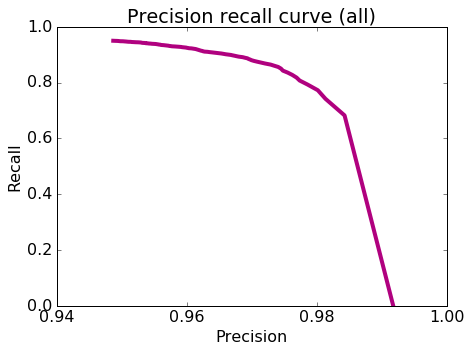

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})
    
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')